In [1]:
# %load utils/measure.py
import time
from functools import wraps

def measure(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter_ns()
        result = func(*args, **kwargs)
        end = time.perf_counter_ns()
        elapsed_ns = end - start
        
        if elapsed_ns < 1_000:
            time_str = f"{elapsed_ns} ns"
        elif elapsed_ns < 1_000_000:
            time_str = f"{elapsed_ns / 1_000:.3f} µs"
        elif elapsed_ns < 1_000_000_000:
            time_str = f"{elapsed_ns / 1_000_000:.3f} ms"
        else:
            time_str = f"{elapsed_ns / 1_000_000_000:.3f} s"
        
        print(f"Performance: {func.__name__}: {time_str}")
        return result
    print("measure-new (util) loaded into global scope.")
    return wrapper


In [2]:
# %load utils/load_libs.py
import matplotlib, math
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import cProfile, pstats

## Fast Inverse Square Root (ID Software Method)

In [3]:
import struct

@measure
def sqrt_id(number):
    """Compute the square root using the Quake III Arena method."""
    threehalfs = 1.5
    
    x2 = number * 0.5
    y = number
    
    # pack the float into bytes, then unpack as int (bit-level manipulation)
    i = struct.unpack('I', struct.pack('f', y))[0]
    i = 0x5f3759df - (i >> 1)  # magic number and bit shift
    
    # convert bits back to float
    y = struct.unpack('f', struct.pack('I', i))[0]
    
    # one iteration of Newton-Raphson method to improve accuracy
    #y = y * (threehalfs - (x2 * y * y))
    # since this gives 1/sqrt(number), take reciprocal to get sqrt

    # 3 iterations of Newton-Raphson — a good sweet spot between performance and accuracy.
    # Result is much closer to the actual sqrt(x) (typically < 0.001 error).
    for _ in range(3):
        y = y * (threehalfs - (x2 * y * y))

    return number * y

n = float(input("enter a number"))

root = sqrt_id(n)
validation = round(root ** 2, 4)

print(f"square root is {root}. Squaring that gives {validation}")

measure-new (util) loaded into global scope.


enter a number 1999


Performance: sqrt_id: 12.275 µs
square root is 44.71017781220973. Squaring that gives 1999.0


## Euclids Alorithm (Greatest Common Divisor)

This algorithm uses the following method

if $n$ **does not divide** $m$ then $m = qn + r$ where q=quotient, r = remainder

Suppose $d$ divides both $m$ and $n$ then $m=ad$ and $n=bd$

$m = qn + r$

$ad = q(bd) + r$

$\to r = cd$

We should ignore the $max(m,n)$, Call the gcd again with the remainer ie $gcd(min(m,n), max \% min)$

Properties of Euclid's Alogrithm
1. time taken is proportional to number of digits in $max (m,n)$
2. one of the first non trivial algorithms

In [37]:
def gcd(m,n):
    (p,q) = (max(m,n), min(m,n))
    if p%q == 0:
        return q
    else:
        return gcd(q,p%q)
@measure
def find_gcd(p,q):
    g = gcd(p,q)
    print(f"gcd of {p}, {q} is {g}")

find_gcd(100,1000)
find_gcd(500,250)
find_gcd(5,7)

measure-new (util) loaded into global scope.
gcd of 100, 1000 is 100
Performance: find_gcd: 9.093 µs
gcd of 500, 250 is 250
Performance: find_gcd: 6.091 µs
gcd of 5, 7 is 1
Performance: find_gcd: 6.814 µs


## Greatest Common Divisor / Highest Common Factor

In [20]:
nums = [501, 20001,-30001]

smallest_num = sorted(abs(i) for i in nums)[0]
gcd = 1

for i in range(1, int(smallest_num) + 1):
    all_divisible = all(num % i == 0 for num in nums)
    if all_divisible:
        if (i not in factors):
            gcd = i
# Time Complexity = min(abs(nums))
print (f"GCD = {gcd}")

GCD = 1


## Find Prime Numbers

In [15]:
def find_factors(n:int) -> list[int]:
    factors = []
    if n > 0:
        for i in range(1, int(math.sqrt(n))+1):
            if n % i == 0:
                if i not in factors:
                    factors.append(i)
                if (n // i) not in factors:
                    factors.append(n // i)
    factors.sort()
    return factors;

@measure
def find_primes_upto(n:int) -> list[int]:
    primes = []
    for i in range(1,n+1):
        factors = find_factors(i)
        if factors == [1,i]: # nice way compared to len(factors) == 2
            primes.append(i)
    return primes


primes = find_primes_upto(100)
print(f"{len(primes)} primes found. {primes}")

measure-new (util) loaded into global scope.
Performance: find_primes_upto: 90.036 µs
25 primes found. [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]


## Find first n Primes

In [41]:
def factors(num):
    facts = []
    for i in range(1, int(math.sqrt(num))+1):
        if (num % i == 0 and i not in facts):
            facts.append(i)
            if (num//i not in facts):
                facts.append(num//i)
    return facts

@measure
def get_n_primes(start_at=2, count=10):
    (index, primes) = (start_at, [])
    
    while len(primes) < count:
        if index >= 1 and factors(index) == [1, index]:
            primes.append(index)
        index += 1
    return primes

nprimes = get_n_primes(start_at=1, count=100)

print(f"{len(nprimes)} primes found. {nprimes}")
            

get_n_primes: 618.31 ms
100 primes found. [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541]


The other prime algorithms that Professor Madhav Mukund is talking of might be
1. Sieve of Atkin
    - Very large set of primes
3. Segmented Sieve
    - for ranges $[L, R]$, where $R$ is huge
4. Miller-Rabin Primality Test (probabilistic)
    - Used for 100+ digit primes
5. AKS Primality Test
    - Theoreticallly important



## Difference Between Primes

measure-new (util) loaded into global scope.
Performance: find_primes_return_difference_freq: 36.824 s


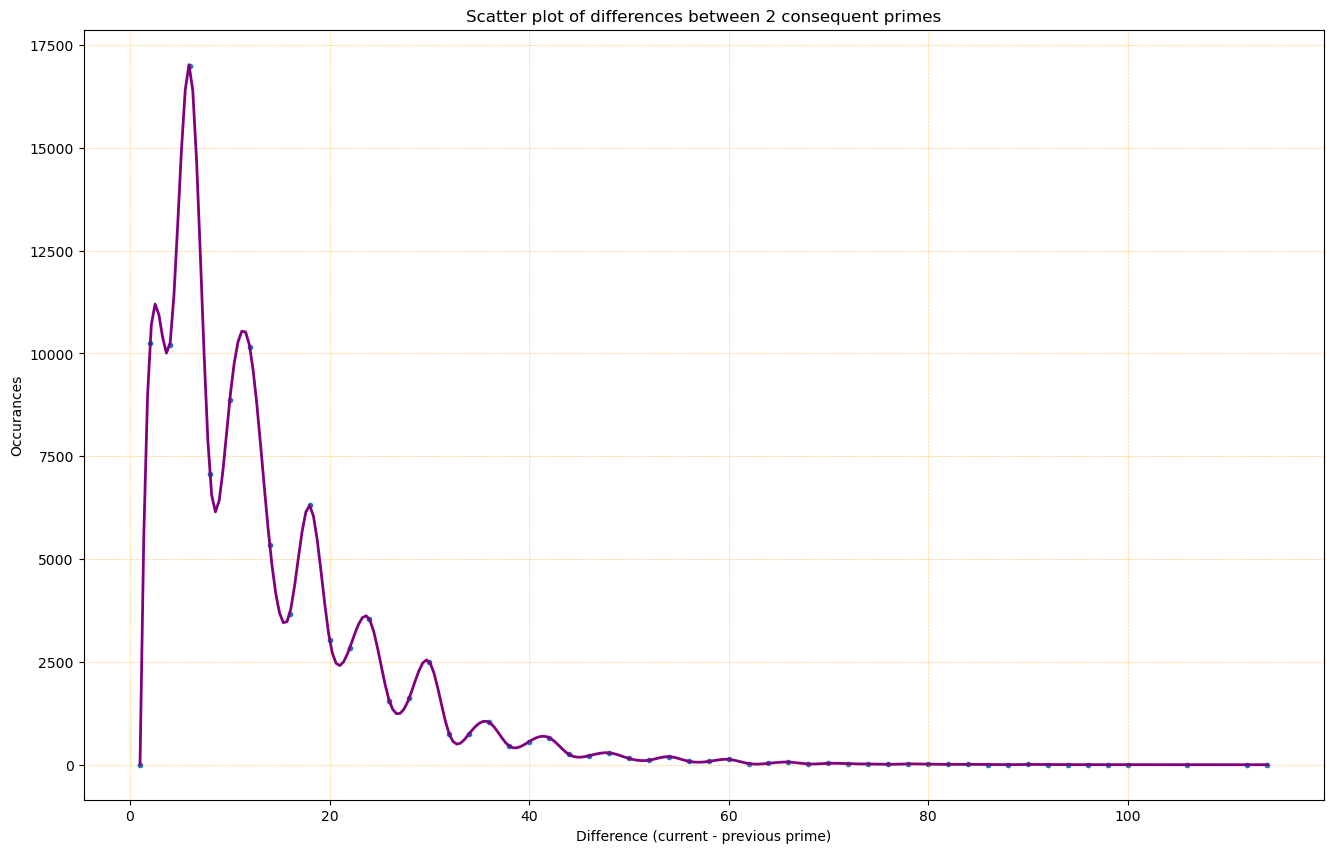

In [26]:
def find_factors(num):
    factors = []
    if num > 0:
        for i in range(1, int(math.sqrt(num)) + 1):
            if num % i == 0:
                if i not in factors:
                    factors.append(i)
                if num//i not in factors:
                    factors.append(num//i)
    return factors


@measure
def find_primes_return_difference_freq(count):
    mapped = {}
    primes = []
    i = 2;
    
    while len(primes) < count:
        if find_factors(i) == [1,i]:
            primes.append(i)
            if (len(primes) > 1):
                diff = primes[-1]-primes[-2]
                if diff in mapped:
                    mapped[diff] += 1
                else:
                    mapped[diff] = 1
        i = i + 1

    return mapped


mapped = find_primes_return_difference_freq(count=100000)

x_axis = sorted([diff for diff in mapped])
y_axis = [mapped[x] for x in x_axis]

plt.figure(figsize=(16,10))
plt.scatter(x_axis, y_axis, s=9)

x_smooth = np.linspace(min(x_axis), max(x_axis), 300)
spline = make_interp_spline(x_axis, y_axis, k=3)
y_smooth = spline(x_smooth)

plt.plot(x_smooth, y_smooth, color='purple', linewidth=2, label='Trend')
plt.grid(True, linestyle='--', color='orange', linewidth=0.5, alpha=0.5)

plt.xlabel("Difference (current - previous prime)")
plt.ylabel("Occurances")
plt.title("Scatter plot of differences between 2 consequent primes")
plt.show()

## Miller Rabin method of Prime Testing

In [34]:
import random

@measure
def is_probable_prime(n, k=5):  # number of tests
    if n <= 1 or n == 4:
        return False
    if n <= 3:
        return True

    # write n-1 as 2^r * d
    d = n - 1
    r = 0
    while d % 2 == 0:
        d //= 2
        r += 1

    for _ in range(k):
        a = random.randint(2, n - 2)
        x = pow(a, d, n)
        if x == 1 or x == n - 1:
            continue
        for _ in range(r - 1):
            x = pow(x, 2, n)
            if x == n - 1:
                break
        else:
            return False
    return True
def test_prime(p):
    print(f"{p} is {'prime' if is_probable_prime(p) else 'not prime'}")

test_prime(32416190071)
test_prime(67280421310721)

measure-new (util) loaded into global scope.
Performance: is_probable_prime: 38.998 µs
32416190071 is prime
Performance: is_probable_prime: 40.849 µs
67280421310721 is prime


# Search Algorithms

## O(N) Search

In [12]:
import random

@measure
def generate_list(n) -> list[int]:
    print(f"generating {n} integers")
    result = [random.randint(1, n) for _ in range(n)]
    return result

@measure
def find(val, lst) -> int:
    pos = 0
    for l in lst:
        if val == l:
            return pos
        pos += 1

    return -1

lst = generate_list(1_000_000)
lst.append(1000988)
print (find(1000988, lst))

measure-new (util) loaded into global scope.
measure-new (util) loaded into global scope.
generating 1000000 integers
Performance: generate_list: 461.897 ms
Performance: find: 39.938 ms
1000000


## $\log_{2}{N}$ Time

In [24]:
def find_internal(val, lst):
    if lst == []:
        return False
    m = len(lst)//2
    if lst[m] == val:
        return True
    if val < lst[m]:
        return find_internal(val, lst[:m])
    else:
        return find_internal(val, lst[m+1:])

@measure
def find(val, lst) -> int:
    return find_internal(val, lst)

@measure
def generate(n):
    lst = list(range(0,n))
    return lst

lst = generate(1_000_000)
lst.append(1000988)
print (find(1000988, lst))

measure-new (util) loaded into global scope.
measure-new (util) loaded into global scope.
Performance: generate: 19.646 ms
Performance: find: 7.425 ms
True


# NMTC Sub Junior

In [1]:
import math

c3 = math.sqrt(2021*2019 + 1)
c2 = math.sqrt(2022*c3 + 1)
c1 = math.sqrt(2023 * c2)

print (c2)


2021.0
